<a href="https://colab.research.google.com/github/doodger/dataScience/blob/development/amazonNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thoughts: not doing data exploration is stupid, no idea what MSE of 1 mean.
Unbalanced classes; undersampling possible?

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()# SPARK_HOMEfrom pyspark.sql import SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [100]:
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3)

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/sql/session.py:346: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!ls drive/'My Drive'
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = spark.read.json("drive/My Drive/Video_Games_5.json")

In [103]:
!ls "drive/My Drive/Video_Games_5.json"

'drive/My Drive/Video_Games_5.json'


In [104]:
df.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|0700099867| [8, 12]|    1.0|Installing the ga...| 07 9, 2012|A2HD75EMZR8QLN|                 123|Pay to unlock con...|    1341792000|
|0700099867|  [0, 0]|    4.0|If you like rally...|06 30, 2013|A3UR8NLLY1ZHCX|Alejandro Henao "...|     Good rally game|    1372550400|
|0700099867|  [0, 0]|    1.0|1st shipment rece...|06 28, 2014|A1INA0F5CWW3J4|Amazon Shopper "M...|           Wrong key|    1403913600|
|0700099867| [7, 10]|    3.0|I got this versio...|09 14, 2011|A1DLMTOTHQ4AST|            ampgreen|awesome game, if ...|    1315958400|
|0700099867|  [2, 2]|    4.0|I had Dirt 2 on X...|06 14

+-------+------------------+
|summary|           overall|
+-------+------------------+
|  count|            231780|
|   mean| 4.086396582966606|
| stddev|1.2023296087789064|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+

[1.0, 1.8, 2.6, 3.4000000000000004, 4.2, 5.0]
[14853, 13663, 28275, 54804, 120185]


(array([ 14853.,  13663.,  28275.,  54804., 120185.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

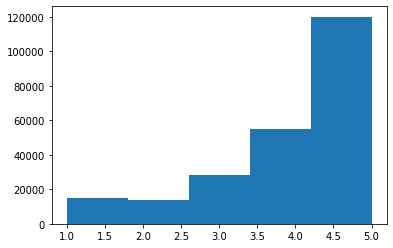

In [164]:
df.select("overall").describe().show()
bins, counts = df.select('overall').rdd.flatMap(lambda x: x).histogram(5)
print(bins)
print(counts)
plt.hist(bins[:-1], bins=bins, weights=counts)


In [0]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol = "reviewText", outputCol = "words")

tokenized = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="words", outputCol = "filtered")
transformed =  remover.transform(tokenized)


In [106]:
transformed.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------------------+--------------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|               words|            filtered|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------------------+--------------------+
|0700099867| [8, 12]|    1.0|Installing the ga...| 07 9, 2012|A2HD75EMZR8QLN|                 123|Pay to unlock con...|    1341792000|[installing, the,...|[installing, game...|
|0700099867|  [0, 0]|    4.0|If you like rally...|06 30, 2013|A3UR8NLLY1ZHCX|Alejandro Henao "...|     Good rally game|    1372550400|[if, you, like, r...|[like, rally, car...|
|0700099867|  [0, 0]|    1.0|1st shipment rece...|06 28, 2014|A1INA0F5CWW3J4|Amazon Shopper "M...|           Wrong 

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, OneHotEncoderEstimator, StringIndexer, CountVectorizer
countVectors = CountVectorizer(inputCol="filtered", outputCol = "countedWords", vocabSize=2000)
model = countVectors.fit(transformed)

In [0]:
newDf = model.transform(transformed)


In [109]:
newDf.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|               words|            filtered|        countedWords|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
|0700099867| [8, 12]|    1.0|Installing the ga...| 07 9, 2012|A2HD75EMZR8QLN|                 123|Pay to unlock con...|    1341792000|[installing, the,...|[installing, game...|(2000,[1,2,3,5,7,...|
|0700099867|  [0, 0]|    4.0|If you like rally...|06 30, 2013|A3UR8NLLY1ZHCX|Alejandro Henao "...|     Good rally game|    1372550400|[if, you, like, r...|[like, rally, car...|(2000,[1,2,3,12,3...|
|070009986

In [0]:
assembler = VectorAssembler(
    inputCols = ["countedWords"],
    outputCol = "features")

output = assembler.transform(newDf)
output = output.select(col("overall").alias("label"),col("features"))


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer


sc.setLogLevel("DEBUG")
(trainingData, testData) = output.randomSplit([0.7,0.3])
gbt = GBTRegressor(featuresCol="features")
###Behzad###
###Doing this works
#gbt.fit(trainingData)
###But then doing this does not
#gbt.transform(testData)
###Neither does
#gbt.predict(testData)

pipeline = Pipeline(stages=[gbt])
model = pipeline.fit(trainingData)
#10 minutes with no max iteration

In [0]:
predictions = model.transform(testData)

In [113]:
predictions.show(100)

+-----+--------------------+-------------------+
|label|            features|         prediction|
+-----+--------------------+-------------------+
|  1.0|        (2000,[],[])|  4.101456845099364|
|  1.0|        (2000,[],[])|  4.101456845099364|
|  1.0|        (2000,[],[])|  4.101456845099364|
|  1.0|(2000,[0,1,2,3,4,...| 3.2613023386400775|
|  1.0|(2000,[0,1,2,3,4,...| 2.8602424306423537|
|  1.0|(2000,[0,1,2,3,4,...|  4.169133229799988|
|  1.0|(2000,[0,1,2,3,4,...| 3.3281720793265204|
|  1.0|(2000,[0,1,2,3,4,...| 2.6012727053986247|
|  1.0|(2000,[0,1,2,3,4,...|0.33282893366344724|
|  1.0|(2000,[0,1,2,3,4,...| 3.8757466660504782|
|  1.0|(2000,[0,1,2,3,4,...| 3.9524280764188893|
|  1.0|(2000,[0,1,2,3,4,...|  3.578799113846432|
|  1.0|(2000,[0,1,2,3,4,...|  4.197586012744731|
|  1.0|(2000,[0,1,2,3,4,...| 1.6990365510923695|
|  1.0|(2000,[0,1,2,3,4,...|  2.404313937818774|
|  1.0|(2000,[0,1,2,3,4,...| 3.9421687540588457|
|  1.0|(2000,[0,1,2,3,4,...| 2.6244287533447803|
|  1.0|(2000,[0,1,2,

In [123]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.07147


,label,features,prediction
0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.101457
1,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.101457
2,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.101457
3,1.0,"(33.0, 7.0, 2.0, 1.0, 1.0, 8.0, 2.0, 1.0, 1.0,...",3.261302
4,1.0,"(19.0, 10.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0...",2.860242
...,...,...,...
69588,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.296401
69589,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.296401
69590,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.101457
69591,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.101457


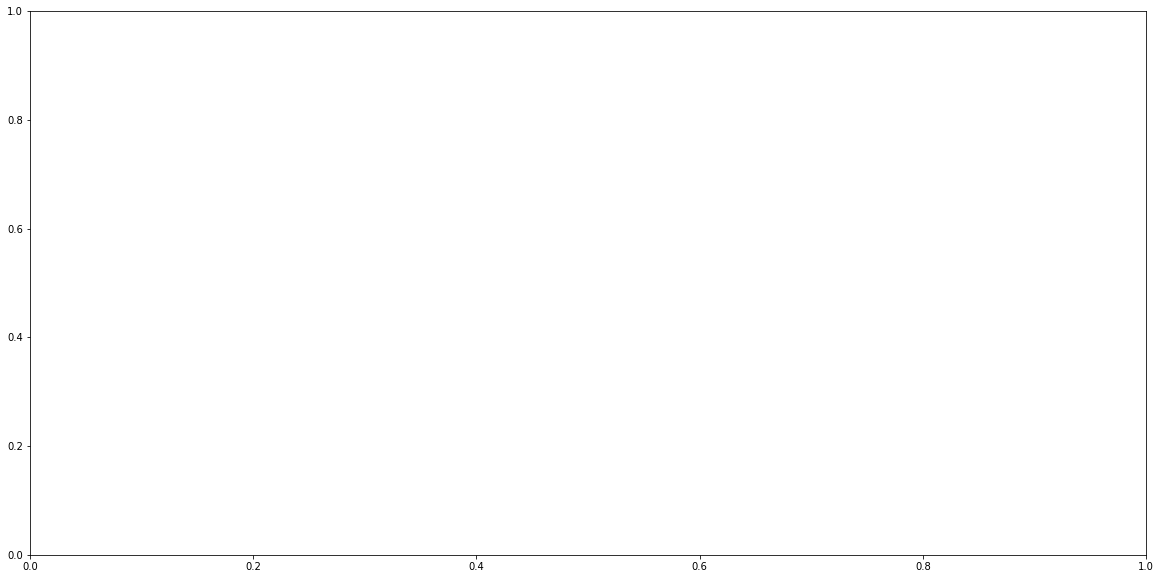

In [139]:

points = predictions.toPandas()



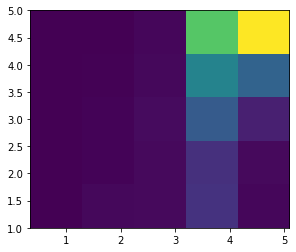

In [147]:
import numpy as np

heatmap, xedges, yedges = np.histogram2d(x=points["prediction"], y=points["label"], bins=5)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

#fig, axes = plt.subplots(ncols=1, nrows=1,figsize=(20,10))
#plt.setp(axes, xlim=(0,10),ylim=(0,3))

#points
#axes.title.set_text("good-bad")
#axes.scatter(x=points["prediction"], y=points["label"])
